In [21]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns

In [3]:
# Importing the dataset
dataset = pd.read_csv('C:\git\Machine-Learning-A-Z-Udemy\data_files\Ads_CTR_Optimisation.csv')
dataset.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


### Primeiro, vamos ver o que aconteria caso as propagandas fossem selecionadas ao acaso para cada usuário

# Exibição Aleatória

In [12]:
# Implementing Random Selection
import random
N = 10000
d = 10
ads_selected = []
total_reward = 0
reward_per_ad = [0]*10

for n in range(N):
    random_ad = random.randrange(d)
    ads_selected.append(random_ad)
    reward = dataset.values[n, random_ad]
    reward_per_ad[random_ad] += reward
    total_reward += reward

1198


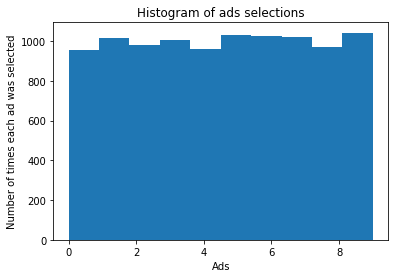

In [8]:
print(total_reward)
# Visualising the results
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

Vemos que o total de cliques nas propagadas foram 1198 e as distribuição das propagandas monstradas foi bem aleatória.
Caso analisemos quanto cada anuncio foi clicado, temos a seguinte distribuição:

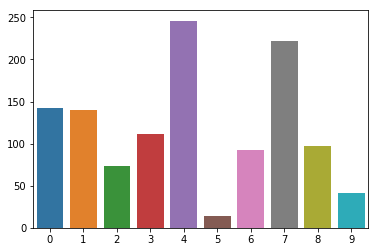

In [20]:
sns.barplot(x=list(range(10)),y=reward_per_ad)

Ao verificarm vemos que os anuncios 4 e 7 tiveram muito mais clique mesmo sendo exibidos na mesma quantidade que os outros, por isso a metodologia do aleatório não é muito eficiente. Vamos agora implementar UCB.

# Upper Confidence Bound (UCB)

In [23]:
# Implementing UCB
N = 10000
d = 10
ads_selected = []
numbers_of_selections = [0] * d
sums_of_reward = [0] * d
total_reward = 0

for n in range(0, N):
    ad = 0
    max_upper_bound = 0
    for i in range(0, d):
        if (numbers_of_selections[i] > 0):
            average_reward = sums_of_reward[i] / numbers_of_selections[i]
            delta_i = math.sqrt(3/2 * math.log(n+1) / numbers_of_selections[i])
            upper_bound = average_reward + delta_i
        else:
            upper_bound = 1e400

        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            ad = i

    ads_selected.append(ad)
    numbers_of_selections[ad] += 1
    reward = dataset.values[n, ad]
    sums_of_reward[ad] += reward
    total_reward += reward

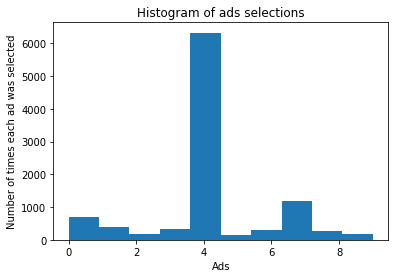

In [24]:
# Visualising the results
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

In [25]:
total_reward

2178

Com o UCB o total de cliques foi 2178, um ganho de 100%. O gráfico de seleção mostra o que já era de imaginar, o anúncio 4 e o 7 obtiveram muito mais exibições.

In [29]:
dataset['Ad 5'].sum()

2695

O algorítmo se baseia no fato que não existe conhecimento prévio, portanto se tivessemos essa informação, era mais fácio exibir apenas o anuncio 4 pois o mesmo teria 2695 cliques!

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import beta

sns.set_style("whitegrid")

class Environment:
    def __init__(self, variants, payouts, n_trials, variance=False):
        self.variants = variants
        if variance:
            self.payouts = np.clip(payouts + np.random.normal(0, 0.04, size=len(variants)), 0, .2)
        else:
            self.payouts = payouts
        #self.payouts[5] = self.payouts[5] if i < n_trials/2 else 0.1
        self.n_trials = n_trials
        self.total_reward = 0
        self.n_k = len(variants)
        self.shape = (self.n_k, n_trials)
        
    def run(self, agent):
        """Run the simulation with the agent. 
        agent must be a class with choose_k and update methods."""
        
        for i in range(self.n_trials):
            # agent makes a choice
            x_chosen = agent.choose_k()
            # Environment returns reward
            reward = np.random.binomial(1, p=self.payouts[x_chosen])
            # agent learns of reward
            agent.reward = reward
            # agent updates parameters based on the data
            agent.update()
            self.total_reward += reward
        
        agent.collect_data()
        
        return self.total_reward

class BaseSampler:
    
    def __init__(self, env, n_samples=None, n_learning=None, e=0.05):
        self.env = env
        self.shape = (env.n_k, n_samples)
        self.variants = env.variants
        self.n_trials = env.n_trials
        self.payouts = env.payouts
        self.ad_i = np.zeros(env.n_trials)
        self.r_i = np.zeros(env.n_trials)
        self.thetas = np.zeros(self.n_trials)
        self.regret_i = np.zeros(env.n_trials)
        self.thetaregret = np.zeros(self.n_trials)
        
        self.a = np.ones(env.n_k) 
        self.b = np.ones(env.n_k) 
        self.theta = np.zeros(env.n_k)
        self.data = None
        self.reward = 0
        self.total_reward = 0
        self.k = 0
        self.i = 0
        
        self.n_samples = n_samples
        self.n_learning = n_learning
        self.e = e
        self.ep = np.random.uniform(0, 1, size=env.n_trials)
        self.exploit = (1 - e)
        
    def collect_data(self):
        
        self.data = pd.DataFrame(dict(ad=self.ad_i, reward=self.r_i, regret=self.regret_i))

In [34]:
class RandomSampler(BaseSampler):
    def __init__(self, env):
        super().__init__(env)
        
    def choose_k(self):
        
        self.k = np.random.choice(self.variants)
        
        return self.k
    
    def update(self):
        # nothing to update
        self.thetaregret[self.i] = np.max(self.theta) - self.theta[self.k]
        
        self.a[self.k] += self.reward
        self.b[self.k] += 1
        self.theta = self.a/self.b

        self.ad_i[self.i] = self.k
        self.r_i[self.i] = self.reward
        self.i += 1

In [35]:
class ThompsonSampler(BaseSampler):

    def __init__(self, env):
        super().__init__(env)
        
    def choose_k(self):
        # sample from posterior (this is the thompson sampling approach)
        # this leads to more exploration because machines with > uncertainty can then be selected as the machine
        self.theta = np.random.beta(self.a, self.b)
        # select machine with highest posterior p of payout
        self.k = self.variants[np.argmax(self.theta)]
        return self.k
    
    def update(self):
       
        #update dist (a, b) = (a, b) + (r, 1 - r) 
        self.a[self.k] += self.reward
        self.b[self.k] += 1 - self.reward # i.e. only increment b when it's a swing and a miss. 1 - 0 = 1, 1 - 1 = 0

        self.thetas[self.i] = self.theta[self.k]
        self.thetaregret[self.i] = np.max(self.thetas) - self.theta[self.k]

        self.ad_i[self.i] = self.k
        self.r_i[self.i] = self.reward
        self.i += 1


In [36]:
list = []

In [37]:
list.a

TypeError: list indices must be integers or slices, not tuple